# Motivating example: Figure 4

Figure below is the motivating example in this paper: *Eliater: an open source software for causal query estimation from observational measurements of biomolecular networks*. This graph contains one mediator $M_1$ that connects the exposure $X$ to the outcome $Y$.

In [1]:
!pip install git+https://github.com/y0-causal-inference/eliater.git 

  Cloning https://github.com/y0-causal-inference/eliater.git to /private/var/folders/fs/kx46_43x04ndj3yryggvkg5r0000gn/T/pip-req-build-21kuke8w
  Running command git clone --quiet https://github.com/y0-causal-inference/eliater.git /private/var/folders/fs/kx46_43x04ndj3yryggvkg5r0000gn/T/pip-req-build-21kuke8w
  Resolved https://github.com/y0-causal-inference/eliater.git to commit 33eb330e6faaa0fce6a0526d4764b800b1c8434c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm, trange

#from eliater import add_ci_undirected_edges, remove_nuisance_variables, version_df, workflow
from eliater import  remove_nuisance_variables
from eliater.discover_latent_nodes import find_nuisance_variables, mark_nuisance_variables_as_latent
# from eliater.examples.frontdoor_backdoor_discrete import (
#     single_mediator_with_multiple_confounders_nuisances_discrete_example as example,
# )
from src.eliater.frontdoor_backdoor import single_mediator_confounders_nuisance_vars_example as example
from eliater.network_validation import print_graph_falsifications
from y0.algorithm.estimation import estimate_ace
from y0.algorithm.identify import identify_outcomes
from y0.dsl import P, Variable, X, Y

#version_df()

In [2]:
SEED = 500

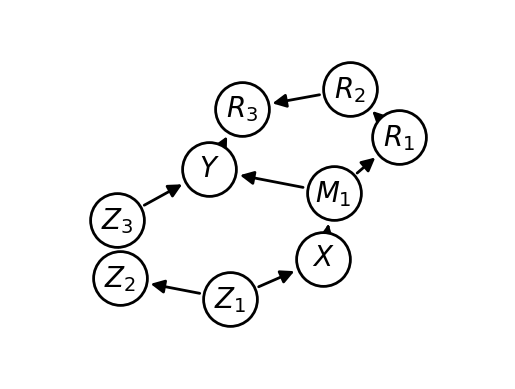

In [3]:
graph = example.graph
graph.draw()

In [4]:
data = example.generate_data(num_samples=1000, seed=SEED)
data.head()

,X,M1,Z1,Z2,Z3,R1,R2,R3,Y
0,1,2.934394,56.979352,22.616432,17.600963,12.276276,5.073340,-2.903520,-2.629445
1,1,2.398253,41.325372,17.927938,17.815860,-2.461589,-3.001966,2.744132,4.287597
2,1,0.170075,47.119159,16.477906,15.465666,-4.784189,-4.581674,-10.634326,1.548849
3,1,2.285580,56.267263,12.351119,11.600543,0.731370,-1.331269,8.751081,26.297357
4,1,-6.300323,69.431847,20.250730,14.255859,-6.614901,-6.511525,0.235470,18.188091


In [5]:
import numpy as np
np.mean(data['X'])

0.862

## Step 1: Verify correctness of the network structure

In [6]:
from sklearn.preprocessing import KBinsDiscretizer
# discretization transform the raw data
kbins = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')
data_trans = kbins.fit_transform(data)
import pandas as pd
data_trans = pd.DataFrame(data_trans, columns = data.columns)

In [7]:
data_trans

,X,M1,Z1,Z2,Z3,R1,R2,R3,Y
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
4,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
995,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
997,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
998,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [8]:
#print_graph_falsifications(graph, data, method="chi-square", verbose=True, significance_level=0.01)
print_graph_falsifications(graph, data_trans, method="chi-square", verbose=True, significance_level=0.01)

Failed tests: 1/26 (3.85%)
Reject null hypothesis when p<0.01
======  =======  =======  ===========  ===========  =====  ===========  ===================
left    right    given          stats            p    dof        p_adj  p_adj_significant
======  =======  =======  ===========  ===========  =====  ===========  ===================
R1      R3       M1|R2    26.9342      2.04974e-05      4  0.000532933  True
Y       Z2       M1|Z3    13.9292      0.00752436       4  0.188109     False
Z1      Z3       Z2        9.64651     0.00804059       2  0.192974     False
R3      Z2       M1|Y      1.59017     0.810558         4  1            False
R2      X        M1        0.680333    0.711652         2  1            False
X       Y        M1|Z1     5.86425     0.209518         4  1            False
M1      R3       R2|Y      9.76467     0.044584         4  1            False
R2      Z1       M1        0.88858     0.641279         2  1            False
M1      R2       R1        4.13818     0.

All the d-separations implied by the network are validated by the data. No test failed. Hence, we can proceed to step 2.

## Step 2: Check query identifiability

The causal query of interest is the average treatment effect of $X$ on $Y$, defined as:
$E[Y|do(X=1)] - E[Y|do(X=0)]$.

In [9]:
identify_outcomes(graph=graph, treatments=X, outcomes=Y)

Sum[M1, Z1, Z2, Z3](P(M1 | X, Z1) * P(Y | M1, X, Z1, Z2, Z3) * P(Z2 | Z1) * P(Z3 | Z1, Z2) * Sum[M1, X, Y, Z2, Z3](Sum[R1, R2, R3](P(M1, R1, R2, R3, X, Y, Z1, Z2, Z3))))

The query is identifiable. Hence we can proceed to step 3.

## Step 3: Find nuisance variables and mark them as latent

This function finds the nuisance variables for the input graph.

In [10]:
find_nuisance_variables(graph, treatments=X, outcomes=Y)

{R1, R2, R3}

The nuisance variables are $R_1$, $R_2$, and $R_3$.

## Step 4: Simplify the network

The following function finds the nuisance variable (step 3), marks them as latent and then applies Evan's simplification rules to remove the nuisance variables. As a result, running the 'find_nuisance_variables' and 'mark_nuisance_variables_as_latent' functions in step 3 is not necessary to get the value of step 4. However, we called them to illustrate the results. The new graph obtained in step 4 does not contain the nuisance variables. 

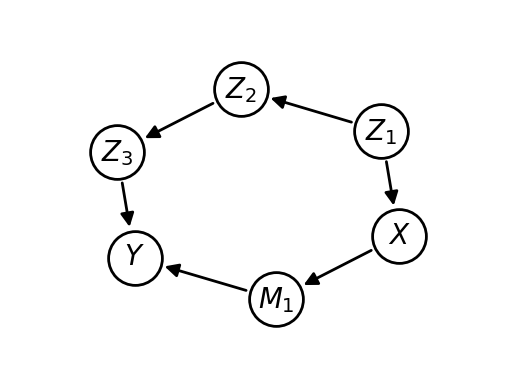

In [11]:
new_graph = remove_nuisance_variables(graph, treatments=X, outcomes=Y)
new_graph.draw()

## Step 5: Estimate the query

In [12]:
ATE_value = estimate_ace(graph=new_graph, treatments=X, outcomes=Y, data=data)
ATE_value

1.192759450311149

The ATE amounts to 0.21 meaning that the average effect that $X$ has on $Y$ is negative.

# Evaluation Criterion

As we used synthetic data set, we were able to generate two interventional data sets where in
one X was set to 1, and the other one X is set to 0. The ATE was calculated by subtracting the average value of Y obtained from each interventional data,
resulting in the ground truth ATE=0.01. The ATE indicates that increase in X can increase  Y levels.

In [13]:
def get_background_ace(seed=None) -> float:
    data_1 = example.generate_data(1000, {X: 1.0}, seed=seed)
    data_0 = example.generate_data(1000, {X: 0.0}, seed=seed)
    return data_1.mean()[Y.name] - data_0.mean()[Y.name]


true_ate = get_background_ace(seed=SEED)
print(f"The true ATE is {true_ate:.04}")

The true ATE is 0.49


### Random Sampling Evaluation

In [14]:
# Population => Generate D = 10000 data points
D = example.generate_data(10000, seed=SEED)

In [15]:
# Samples => Generate 1000 datasets with 1000 points each (d) using random sampling

d_count = 1000
d_size = 1000
d = [D.sample(d_size) for _ in range(d_count)]

In [16]:
ate_new_graph = [estimate_ace(new_graph, treatments=X, outcomes=Y, data=data) for data in d]

In [17]:
ate_graph = [estimate_ace(graph, treatments=X, outcomes=Y, data=data) for data in d]

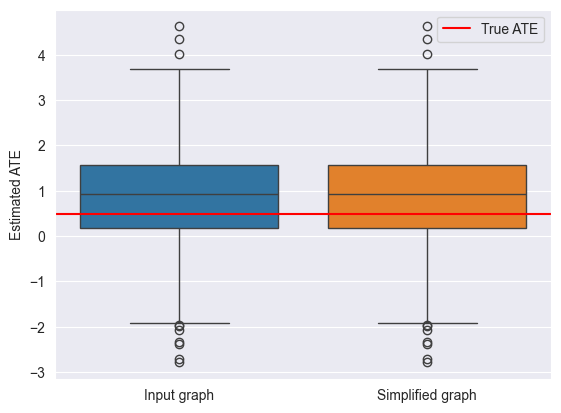

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({"Input graph": ate_graph, "Simplified graph": ate_new_graph})
ax = sns.boxplot(data=df)
ax.axhline(y=get_background_ace(seed=SEED), label="True ATE", color='r')
ax.set(ylabel="Estimated ATE")
ax.legend()

In [ ]:
#TODO for Pruthvi: generate a plot that contains two boxplots. One for ate_new_graph and one for ate_graph. Look at the example in Sars case stud to get an idea of how to do it. Add a horizontal line of 0.49 to the plot which is the true ATE. 

# Additional Analysis

Some questions charlie wants to answer:

1. Is there a meaningful effect of doing reduction of nuissance variables?
2. What is the effect of picking the random seed?
3. How do I contextualize all of these numbers that are dropped in here? When is an ACE significant, i.e., how do I know 0.21 is a big enough number (or different enough from some other number) that X has a meaningful negative effect on Y?

In [16]:
repeats = 500
datasets = [
    example.generate_data(num_samples=500, seed=seed)
    for seed in trange(repeats, desc="Generating datasets", leave=False)
]
background_ates = [get_background_ace(seed=seed) for seed in trange(repeats, leave=False)]
unreduced_aces = [
    estimate_ace(graph=graph, treatments=X, outcomes=Y, data=data)
    for data in tqdm(datasets, desc="No Workflow ATEs", leave=False)
]
reduced_aces = [
    estimate_ace(
        graph=remove_nuisance_variables(graph, treatments=X, outcomes=Y),
        treatments=X,
        outcomes=Y,
        data=data,
    )
    for data in tqdm(datasets, desc="Workflow ATEs", leave=False)
]

Generating datasets:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

No Workflow ATEs:   0%|          | 0/500 [00:00<?, ?it/s]

Workflow ATEs:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Does Reducing Nuissance Variables Matter?

In the experiment below, I create several random datasets and for each see if adding the removal of nuissance variables changes the resulting ACE by taking the difference between the ACE calculated on the original graph vs the reduced graph.

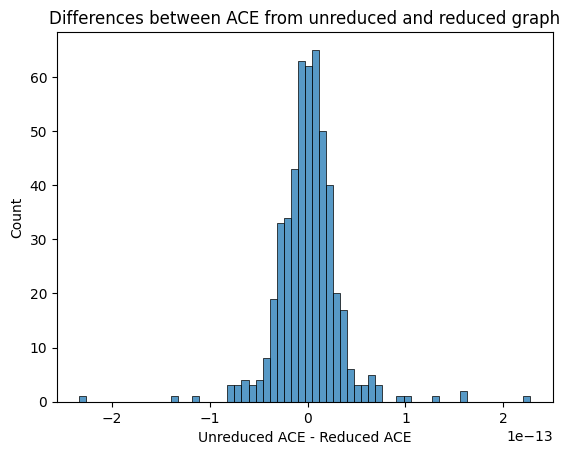

In [12]:
differences = [
    unreduced_ace - reduced_ace for unreduced_ace, reduced_ace in zip(unreduced_aces, reduced_aces)
]
sns.histplot(differences)
plt.title("Differences between ACE from unreduced and reduced graph")
plt.xlabel("Unreduced ACE - Reduced ACE")
plt.show()

We're in the numerical instability region since this graph is on the scale of 1e-13 - this seems to indicate that reducing the latent variables from the graph does not have an effect on the ACE.

# What's the effect of random seed?

In the experiment above, a random seed of `seed=500` was generated which resulted in a "true" ATE and a "calculated" ATE. The conclusion was that because the calculated ATE was positive, that the treatment (X) had a negative effect on the outcome (Y). A few follow-up questions:

1. What's the correspondence between these numbers? Should they be the same, or different, and by how much?
2. What happens if we pick different random seeds?

Below, I picked several different random seeds and calculated the differences, and got this chart. You can see that sometimes, the difference is positive, negative, or close to zero. This means we need a better way of interpreting these results, otherwise setting the random seed is effectively cherry picking.

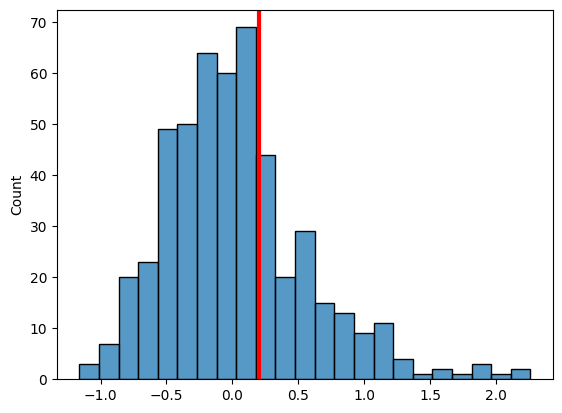

In [13]:
differences = [
    background_ate - unreduced_ate
    for background_ate, unreduced_ate in zip(background_ates, unreduced_aces)
]

sns.histplot(differences, label="Generated ACEs")
plt.axvline(ATE_value - true_ate, linewidth=3, color="red")
plt.show()